In [16]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import h5py
import scipy.linalg

filename = "C:/Users/realc/OneDrive/Documents/GSOC/data/QG1_normalized_16_xl"
# filename = "../../data/QG_train_normalized_16_xl"
data_X = np.array(h5py.File(filename, "r")['X'])

def scramble_state_vectors(encoded_data, seed):
    np.random.seed(seed)
    scrambled_vectors = []
    for i in range(len(encoded_data)):
        # scrambled_state = np.random.permutation(encoded_data[i].flatten())
        gaussian_matrix = np.random.normal(0, 0.1, (16, 16))
        scrambled_state = np.multiply(gaussian_matrix, encoded_data[i])
        scrambled_vectors.append(scrambled_state)
    return np.array(scrambled_vectors).reshape(len(encoded_data), 8, 8, 4)

def reshape_scrambled_states(scrambled_states):
    reshaped_scrambled_states = scrambled_states.reshape(scrambled_states.shape[0], 8, 8, 4)
    return reshaped_scrambled_states

input_dim = 8 * 8 * 4
hidden_dim = 128
output_dim = 8 * 8 * 4

num_samples = 1000

scrambled_states = scramble_state_vectors(data_X[:num_samples], seed=42)
scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32).view(num_samples, -1)
encoded_data = torch.tensor(data_X[:num_samples], dtype=torch.float32).view(num_samples, -1)

Epoch [1/50], Loss: 0.0128, Val Loss: 0.0123, FID: 3.2680
Epoch [2/50], Loss: 0.0124, Val Loss: 0.0120, FID: 3.1792
Epoch [3/50], Loss: 0.0121, Val Loss: 0.0116, FID: 3.0960
Epoch [4/50], Loss: 0.0117, Val Loss: 0.0113, FID: 3.0176
Epoch [5/50], Loss: 0.0114, Val Loss: 0.0110, FID: 2.9436
Epoch [6/50], Loss: 0.0111, Val Loss: 0.0107, FID: 2.8737
Epoch [7/50], Loss: 0.0108, Val Loss: 0.0105, FID: 2.8075
Epoch [8/50], Loss: 0.0105, Val Loss: 0.0102, FID: 2.7447
Epoch [9/50], Loss: 0.0103, Val Loss: 0.0100, FID: 2.6851
Epoch [10/50], Loss: 0.0101, Val Loss: 0.0098, FID: 2.6283
Epoch [11/50], Loss: 0.0098, Val Loss: 0.0095, FID: 2.5743
Epoch [12/50], Loss: 0.0096, Val Loss: 0.0093, FID: 2.5227
Epoch [13/50], Loss: 0.0094, Val Loss: 0.0091, FID: 2.4734
Epoch [14/50], Loss: 0.0092, Val Loss: 0.0089, FID: 2.4265
Epoch [15/50], Loss: 0.0090, Val Loss: 0.0087, FID: 2.3817
Epoch [16/50], Loss: 0.0088, Val Loss: 0.0086, FID: 2.3390
Epoch [17/50], Loss: 0.0086, Val Loss: 0.0084, FID: 2.2983
Epoch 

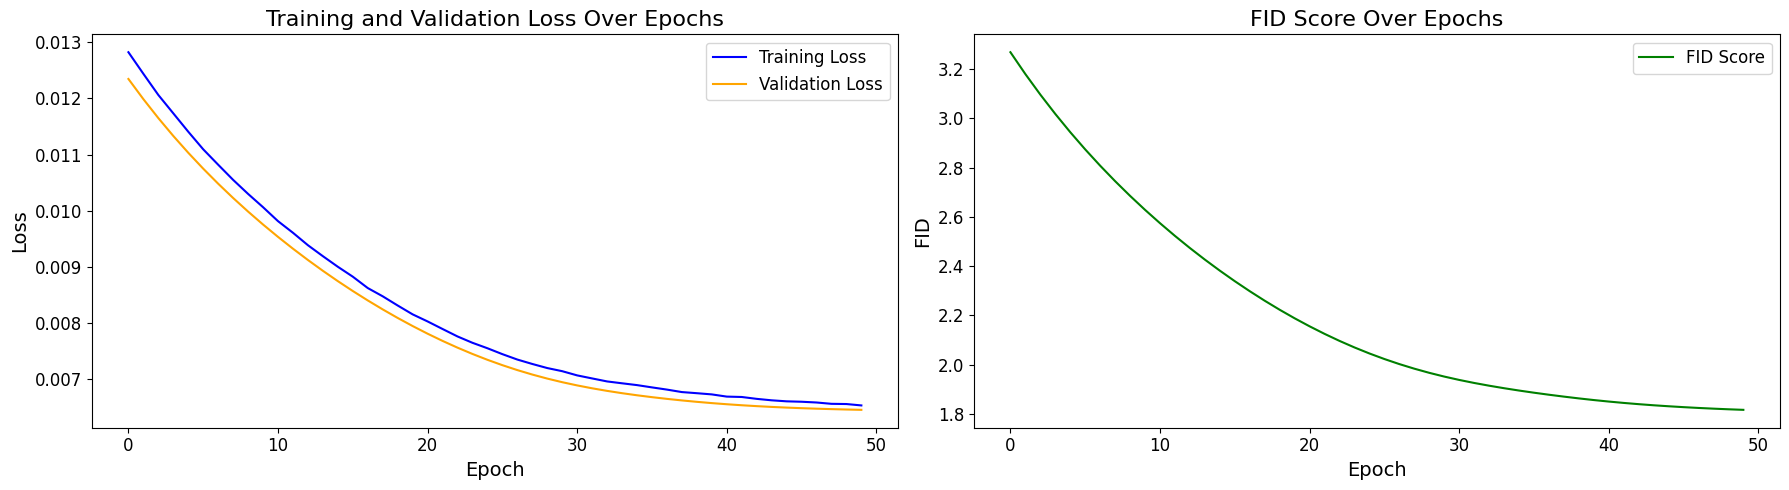

In [ ]:
from sklearn.model_selection import train_test_split

train_encoded_data, val_encoded_data, train_scrambled_states, val_scrambled_states = train_test_split(
    encoded_data, scrambled_states, test_size=0.2, random_state=42, shuffle=True
)

class ClassicalDiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ClassicalDiffusionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

def decode(encoded_data):
    num_samples, encoded_height, encoded_width, num_channels = encoded_data.shape
    decoded_data = np.zeros((num_samples, 16, 16))

    for sample in range(num_samples):
        for i in range(encoded_height):
            for j in range(encoded_width):
                for c in range(num_channels):
                    if c == 0:
                        decoded_data[sample, 2*i, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 1:
                        decoded_data[sample, 2*i, 2*j+1] = encoded_data[sample, i, j, c]
                    elif c == 2:
                        decoded_data[sample, 2*i+1, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 3:
                        decoded_data[sample, 2*i+1, 2*j+1] = encoded_data[sample, i, j, c]

    return decoded_data

def flip(decoded_data):
    return 1 - decoded_data

def calculate_statistics(data):
    data = data.reshape(data.shape[0], -1)  # flatten images
    mean = np.mean(data, axis=0)
    covariance = np.cov(data, rowvar=False)
    return mean, covariance

def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    diff = mu1 - mu2
    covmean, _ = scipy.linalg.sqrtm(sigma1 @ sigma2, disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff @ diff + np.trace(sigma1) + np.trace(sigma2) - 2 * np.trace(covmean)
    return fid

input_dim = train_scrambled_states.view(len(train_scrambled_states), -1).shape[1]
hidden_dim = 64 
output_dim = train_encoded_data.view(len(train_encoded_data), -1).shape[1]

model = ClassicalDiffusionModel(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
loss_values = []
val_loss_values = []
fid_scores = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_scrambled_states.view(len(train_scrambled_states), -1))
    loss = criterion(outputs, train_encoded_data.view(len(train_encoded_data), -1))
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_scrambled_states.view(len(val_scrambled_states), -1))
        val_loss = criterion(val_outputs, val_encoded_data.view(len(val_encoded_data), -1))
        val_loss_values.append(val_loss.item())
        
        denoised_states = model(val_scrambled_states.view(len(val_scrambled_states), -1))
        denoised_states = denoised_states.view(len(val_scrambled_states), 8, 8, 4).detach().numpy()
        decoded_data = decode(denoised_states)
        decoded_data = decoded_data

        mu1, sigma1 = calculate_statistics(data_X[:len(decoded_data)])
        mu2, sigma2 = calculate_statistics(decoded_data)
        fid = calculate_fid(mu1, sigma1, mu2, sigma2)
        fid_scores.append(fid)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, FID: {fid:.4f}')

plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_values, label='Training Loss', color='blue')
plt.plot(val_loss_values, label='Validation Loss', color='orange')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss Over Epochs', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(fid_scores, label='FID Score', color='green')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('FID', fontsize=14)
plt.title('FID Score Over Epochs', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


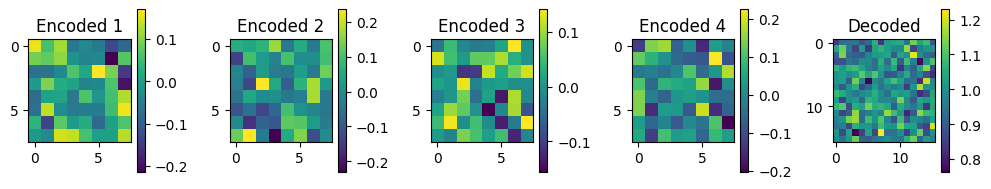

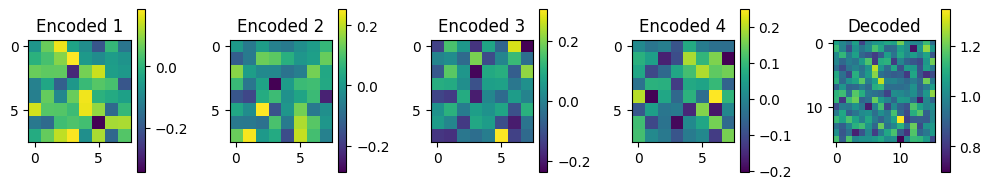

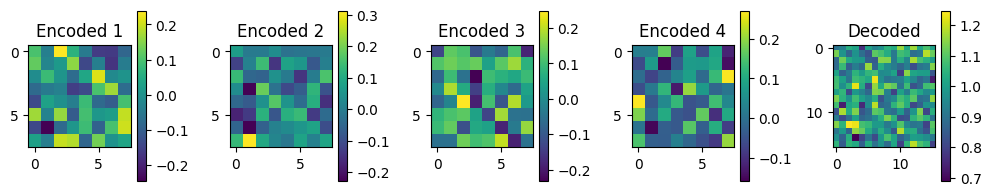

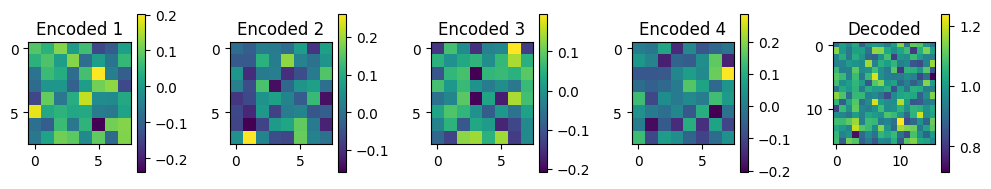

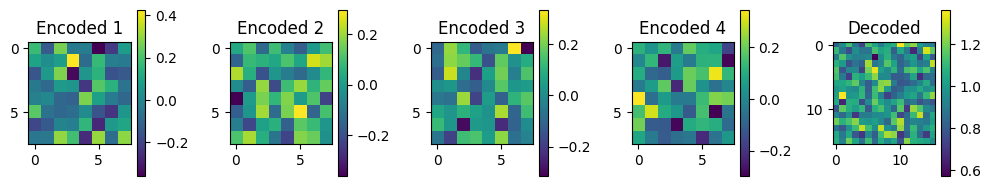

In [15]:
def generate_new_images(model, num_images, input_dim=8*8*4):
    model.eval()
    with torch.no_grad():
        random_noise = torch.randn(num_images, input_dim)
        generated_data = model(random_noise)
        generated_data = generated_data.view(num_images, 8, 8, 4).detach().numpy()
        decoded_images = flip(decode(generated_data))
        
        for i in range(num_images):
            fig, axes = plt.subplots(1, 5, figsize=(10, 2))
            for qubit in range(4):
                im = axes[qubit].imshow(generated_data[i, :, :, qubit], cmap='viridis')
                axes[qubit].set_title(f"Encoded {qubit+1}")
                fig.colorbar(im, ax=axes[qubit])
            im = axes[4].imshow(decoded_images[i], cmap='viridis')
            axes[4].set_title("Decoded")
            fig.colorbar(im, ax=axes[4])
            plt.tight_layout()
            plt.show()
    return decoded_images

num_samples_to_generate = 5
new_images = generate_new_images(model, num_samples_to_generate)